In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os
import itertools

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

import time

%matplotlib inline

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']


2450083.5


In [3]:
sorce = Table.read("./SORCE/sorce_L3_combined_c24h_20030225_20200225.txt", format="ascii.no_header", guess=False, fast_reader=False, comment=";", data_start=0)

In [4]:
print(sorce)

   col1       col2     col3    col4  col5 col6     col7        col8     col9 
---------- --------- ------- ------- ---- ---- ------------ ---------- ------
20030225.5 2452696.0     0.0     1.0   57   12 1.315986e-06   0.074467    0.0
20030225.5 2452696.0     1.0     2.0   57   12 4.265072e-05   0.074467    0.0
20030225.5 2452696.0     2.0     3.0   57   12  4.07242e-05   0.074467    0.0
20030225.5 2452696.0     3.0     4.0   57   12 3.418736e-05   0.074467    0.0
20030225.5 2452696.0     4.0     5.0   57   12 3.996532e-05   0.074467    0.0
20030225.5 2452696.0     5.0     6.0   57   12 5.403339e-05   0.074467    0.0
20030225.5 2452696.0     6.0     7.0   57   12 6.715881e-05   0.074467    0.0
20030225.5 2452696.0     7.0     8.0   57   12 5.345153e-05   0.074467    0.0
20030225.5 2452696.0     8.0     9.0   57   12 4.856349e-05   0.074467    0.0
20030225.5 2452696.0     9.0    10.0   57   12 3.867245e-05   0.074467    0.0
       ...       ...     ...     ...  ...  ...          ...     

In [5]:
sorce.rename_column('col1', 'yyyymmdd')
sorce.rename_column('col2','jd')
sorce.rename_column('col3','min_wavelength')
sorce.rename_column('col4','max_wavelength')
sorce.rename_column('col5','instrument_mode_id')
sorce.rename_column('col6','data_version')  
sorce.rename_column('col7','irradiance')
sorce.rename_column('col8','irradiance_uncertainty') 
sorce.rename_column('col9','quality')
print(sorce)

 yyyymmdd      jd    min_wavelength ... irradiance_uncertainty quality
---------- --------- -------------- ... ---------------------- -------
20030225.5 2452696.0            0.0 ...               0.074467     0.0
20030225.5 2452696.0            1.0 ...               0.074467     0.0
20030225.5 2452696.0            2.0 ...               0.074467     0.0
20030225.5 2452696.0            3.0 ...               0.074467     0.0
20030225.5 2452696.0            4.0 ...               0.074467     0.0
20030225.5 2452696.0            5.0 ...               0.074467     0.0
20030225.5 2452696.0            6.0 ...               0.074467     0.0
20030225.5 2452696.0            7.0 ...               0.074467     0.0
20030225.5 2452696.0            8.0 ...               0.074467     0.0
20030225.5 2452696.0            9.0 ...               0.074467     0.0
       ...       ...            ... ...                    ...     ...
20200225.5 2458905.0        2311.89 ...              0.0003176  5122.0
202002

In [6]:
sorce['avg_wavelength'] = (sorce['min_wavelength']+sorce['max_wavelength'])/2.

In [7]:
# the short-wavelength instrument, covering the EIT bands
XPSmask = (sorce['instrument_mode_id'] == 57)
print(len(sorce[XPSmask]))
print(sorce[XPSmask])

print(len(np.unique(sorce['jd'][XPSmask]))/365.) #~16 years of observations
print(np.min(sorce['yyyymmdd'][XPSmask]))        #beginning late february 2003
print(np.max(sorce['yyyymmdd'][XPSmask]))        #ending late february 2020

234720
 yyyymmdd      jd    min_wavelength ... quality avg_wavelength
---------- --------- -------------- ... ------- --------------
20030225.5 2452696.0            0.0 ...     0.0            0.5
20030225.5 2452696.0            1.0 ...     0.0            1.5
20030225.5 2452696.0            2.0 ...     0.0            2.5
20030225.5 2452696.0            3.0 ...     0.0            3.5
20030225.5 2452696.0            4.0 ...     0.0            4.5
20030225.5 2452696.0            5.0 ...     0.0            5.5
20030225.5 2452696.0            6.0 ...     0.0            6.5
20030225.5 2452696.0            7.0 ...     0.0            7.5
20030225.5 2452696.0            8.0 ...     0.0            8.5
20030225.5 2452696.0            9.0 ...     0.0            9.5
       ...       ...            ... ...     ...            ...
20200224.5 2458904.0           30.0 ...     0.0           30.5
20200224.5 2458904.0           31.0 ...     0.0           31.5
20200224.5 2458904.0           32.0 ...     0.0 

0.0064844
0.21365
2.990993e-08
0.0006793849


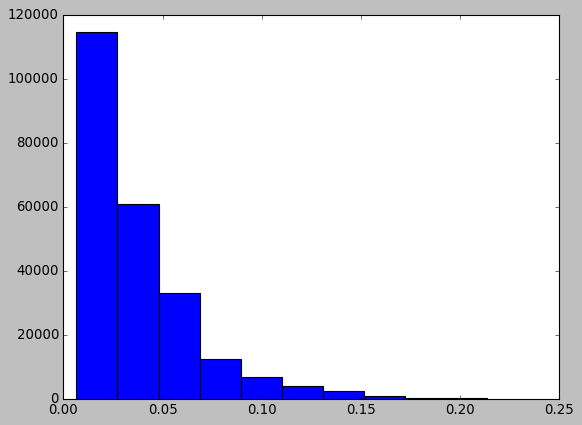

In [8]:
plt.hist(sorce['irradiance_uncertainty'][XPSmask])
print(np.min(sorce['irradiance_uncertainty'][XPSmask]))
print(np.max(sorce['irradiance_uncertainty'][XPSmask]))

print(np.min(sorce['irradiance'][XPSmask]))
print(np.max(sorce['irradiance'][XPSmask]))

In [9]:
mask = (sorce['jd']==2458903.0)
print(len(sorce[mask]))
print(sorce[mask]['min_wavelength','max_wavelength','avg_wavelength'][0:40]) 
print(sorce[mask]['irradiance','irradiance_uncertainty'][0:40]) 
#note that these are all in nanometers!

985
min_wavelength max_wavelength avg_wavelength
-------------- -------------- --------------
           0.0            1.0            0.5
           1.0            2.0            1.5
           2.0            3.0            2.5
           3.0            4.0            3.5
           4.0            5.0            4.5
           5.0            6.0            5.5
           6.0            7.0            6.5
           7.0            8.0            7.5
           8.0            9.0            8.5
           9.0           10.0            9.5
           ...            ...            ...
          30.0           31.0           30.5
          31.0           32.0           31.5
          32.0           33.0           32.5
          33.0           34.0           33.5
          34.0           35.0           34.5
          35.0           36.0           35.5
          36.0           37.0           36.5
          37.0           38.0           37.5
          38.0           39.0           38.5
      

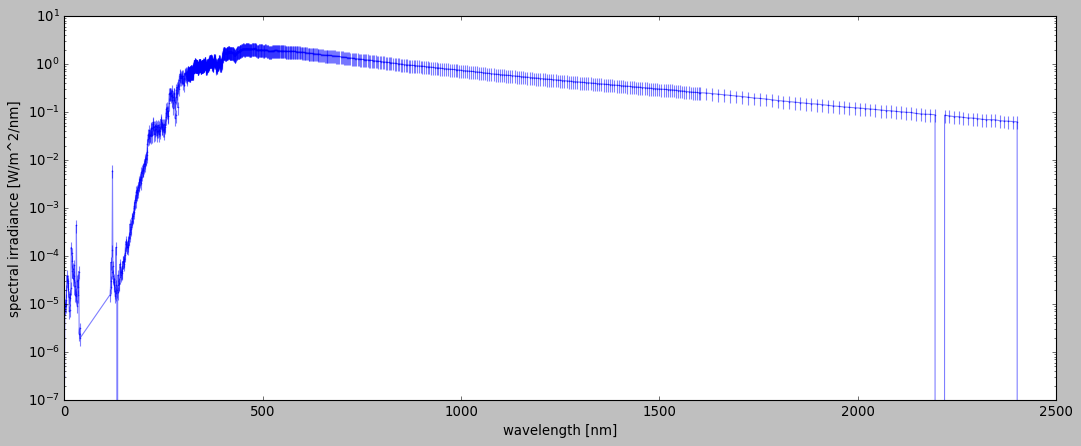

In [10]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'], yerr=0.3*sorce[mask]['irradiance'], marker='.',capsize=0,elinewidth=1, ms=2, alpha=0.5,ls='-')
#ax.plot(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'], 'b-',marker='.')

ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("spectral irradiance [W/m^2/nm]")
ax.set_yscale("log")
plt.show()

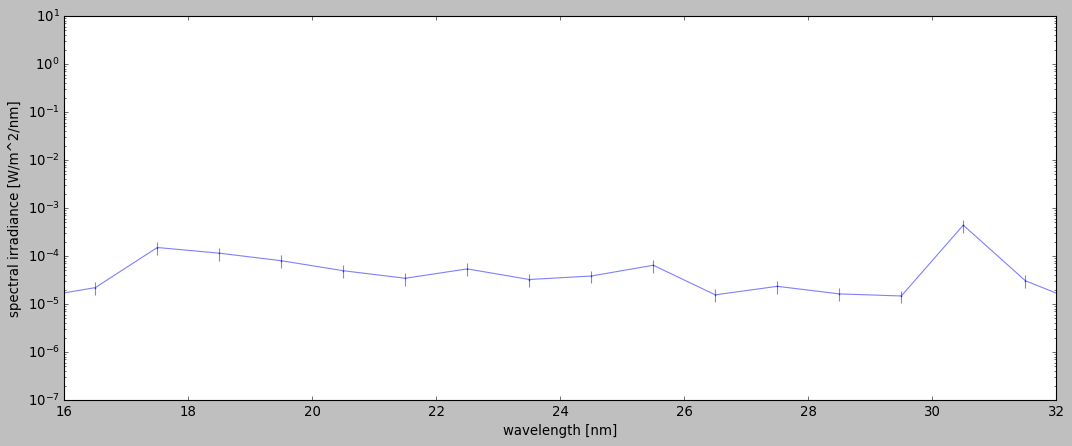

In [11]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'], yerr=0.3*sorce[mask]['irradiance'], marker='.',capsize=0,elinewidth=1, ms=2, alpha=0.5,ls='-')
#ax.plot(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'], 'b-',marker='.')

ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("spectral irradiance [W/m^2/nm]")
ax.set_yscale("log")
ax.set_xlim(16,32)
plt.show()

In [104]:
# results of digitizing figure 8 of Newmark et al 2000
# note that these are pre-flight calibration curves and do not include detector degradation. Assume that
# the soho pipeline has otherwise accounted for that (for now).
#filt171 = np.genfromtxt("./EIT/filterResponse/newmark+2000_fig8_171angstrom_digitized.txt")
#filt195 = np.genfromtxt("./EIT/filterResponse/newmark+2000_fig8_195angstrom_digitized.txt")
#filt284 = np.genfromtxt("./EIT/filterResponse/newmark+2000_fig8_284angstrom_digitized.txt")
#filt304 = np.genfromtxt("./EIT/filterResponse/newmark+2000_fig8_304angstrom_digitized.txt")

filt171 = np.genfromtxt("./EIT/filterResponse/dere+2000_table6_171angstrom_effectiveArea.txt")[:-1] #chop off last row, there's a strange uptick that doesn't appear in fig 11 of Dere et al.
filt195 = np.genfromtxt("./EIT/filterResponse/dere+2000_table7_195angstrom_effectiveArea.txt")
filt284 = np.genfromtxt("./EIT/filterResponse/dere+2000_table8_284angstrom_effectiveArea.txt")
filt304 = np.genfromtxt("./EIT/filterResponse/dere+2000_table9_304angstrom_effectiveArea.txt")


#results of digitizing figure 23 of Hovestadt et al. 1995, CELIAS-SEM bandpasses
sem0 = np.genfromtxt("./CELIAS-SEM/0th_order_bandpass_hovestadt+1995_fig23_digitized.txt")
sem1 = np.genfromtxt("./CELIAS-SEM/1st_order_bandpass_hovestadt+1995_fig23_digitized.txt")

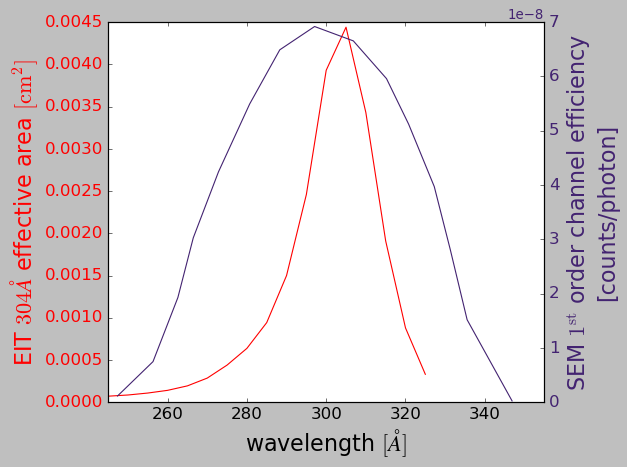

In [105]:
# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r'wavelength $[\AA]$', fontsize=20)
ax1.set_ylabel(r'EIT $304\AA$ effective area '+r'$[\mathrm{cm}^{2}]$', color='r', fontsize=20)
ax1.plot(filt304[:,0],filt304[:,3], color='r')
ax1.tick_params(axis='y', labelcolor='r', labelsize=15)
ax1.tick_params(axis='x',labelsize=15)
ax1.set_xlim(245,355)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

ax2.set_ylabel(r'SEM $1^{\mathrm{st}}$ order channel efficiency'+'\n'+'[counts/photon]', color='#432371',fontsize=20)  # we already handled the x-label with ax1
ax2.plot(sem1[:,0]*10, sem1[:,1], color='#432371')
ax2.tick_params(axis='y', labelcolor='#432371',labelsize=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("./EIT304Bandpass_vs_SEM1stOrderBandpass.pdf",bbox_inches="tight")

In [106]:
def linearlyInterpolateSpectrumAngstroms(wavelength, flux):
    '''
    linearly interpolate the spectrum to angstrom rather than nm scales
    '''
    interp_wavelength = np.zeros((len(wavelength) - 1)*10, dtype=float)
    interp_flux = np.zeros((len(wavelength) - 1)*10, dtype=float)

    for i in range(len(wavelength) - 1):
        for j in range(10):
            interp_wavelength[(10*i) + j] = wavelength[i] + 0.1*j
            interp_flux[(10*i) + j] = flux[i] + (flux[i+1] - flux[i])*(0.1*j)
    
    return interp_wavelength, interp_flux

In [107]:
print(filt171[:,0])
print(filt195[:,0])
print(filt284[:,0])
print(filt304[:,0])

[168. 170. 172. 174. 176. 178. 180. 182. 184.]
[175. 180. 185. 190. 195. 200. 205. 210. 215.]
[175. 180. 185. 190. 195. 200. 205. 210. 215. 220. 225. 230. 235. 240.
 245. 250. 255. 260. 265. 270. 275. 280. 285. 290. 295. 300. 305.]
[150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205. 210. 215.
 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275. 280. 285.
 290. 295. 300. 305. 310. 315. 320. 325.]


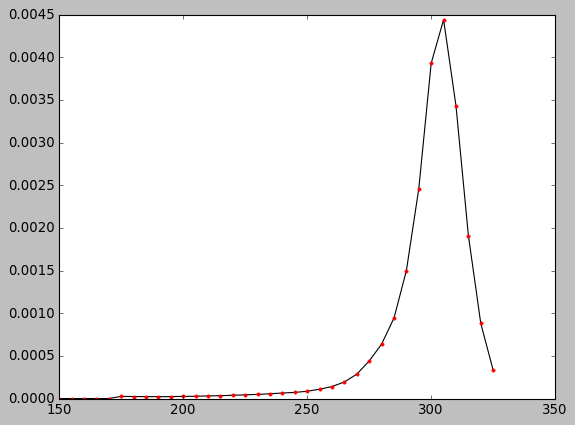

In [108]:
filt171_everywavelength_w = np.arange(168, 185)
filt171_everywavelength_f = np.zeros_like(filt171_everywavelength_w).astype(float)

for i, w in enumerate(np.arange(168,185)):
    if i % 2 == 0:
        filt171_everywavelength_f[i] = filt171[int(i/2), 3]
    else:
        filt171_everywavelength_f[i] = 0.5*(filt171[int((i-1)/2), 3] + filt171[int((i+1)/2), 3])

filt195_everywavelength_w = np.arange(175, 216)
filt195_everywavelength_f = np.zeros_like(filt195_everywavelength_w).astype(float)

for i, w in enumerate(np.arange(175,216)):
    if i % 5 == 0:
        filt195_everywavelength_f[i] = filt195[int(i/5), 3]
        this5 = int(i/5)
        next5 = int(i/5) + 1
    else:
        filt195_everywavelength_f[i] = filt195[this5, 3] + ((i%5)/5.) * (filt195[next5, 3] - filt195[this5, 3]) 
        
filt284_everywavelength_w = np.arange(175, 306)
filt284_everywavelength_f = np.zeros_like(filt284_everywavelength_w).astype(float)

for i, w in enumerate(np.arange(175,306)):
    if i % 5 == 0:
        filt284_everywavelength_f[i] = filt284[int(i/5), 3]
        this5 = int(i/5)
        next5 = int(i/5) + 1
    else:
        filt284_everywavelength_f[i] = filt284[this5, 3] + ((i%5)/5.) * (filt284[next5, 3] - filt284[this5, 3]) 


filt304_everywavelength_w = np.arange(150, 326)
filt304_everywavelength_f = np.zeros_like(filt304_everywavelength_w).astype(float)

for i, w in enumerate(np.arange(150,326)):
    if i % 5 == 0:
        filt304_everywavelength_f[i] = filt304[int(i/5), 3]
        this5 = int(i/5)
        next5 = int(i/5) + 1
    else:
        filt304_everywavelength_f[i] = filt304[this5, 3] + ((i%5)/5.) * (filt304[next5, 3] - filt304[this5, 3]) 

        
fig, ax = plt.subplots(1,1)
ax.plot(filt304_everywavelength_w, filt304_everywavelength_f, 'k-')
ax.plot(filt304[:,0], filt304[:,3],'r.')
plt.show()

In [109]:
filterSumWavelengths = np.arange(150.,327.)
filterSumTransmission = np.zeros_like(filterSumWavelengths)
"""
# for newmark+2000 filter files
filterSumTransmission[(filterSumWavelengths >= filt171[0,0]) & (filterSumWavelengths <= filt171[-1,0])] += filt171[:,1]
filterSumTransmission[(filterSumWavelengths >= filt195[0,0]) & (filterSumWavelengths <= filt195[-1,0])] += filt195[:,1]
filterSumTransmission[(filterSumWavelengths >= filt284[0,0]) & (filterSumWavelengths <= filt284[-1,0])] += filt284[:,1]
filterSumTransmission[(filterSumWavelengths >= filt304[0,0]) & (filterSumWavelengths <= filt304[-1,0])] += filt304[:,1]
"""

# for dere+2000 filter files, which have coarser wavelength coverage
filterSumTransmission[(filterSumWavelengths >= filt171_everywavelength_w[0]) & (filterSumWavelengths <= filt171_everywavelength_w[-1])] += filt171_everywavelength_f
filterSumTransmission[(filterSumWavelengths >= filt195_everywavelength_w[0]) & (filterSumWavelengths <= filt195_everywavelength_w[-1])] += filt195_everywavelength_f
filterSumTransmission[(filterSumWavelengths >= filt284_everywavelength_w[0]) & (filterSumWavelengths <= filt284_everywavelength_w[-1])] += filt284_everywavelength_f
filterSumTransmission[(filterSumWavelengths >= filt304_everywavelength_w[0]) & (filterSumWavelengths <= filt304_everywavelength_w[-1])] += filt304_everywavelength_f


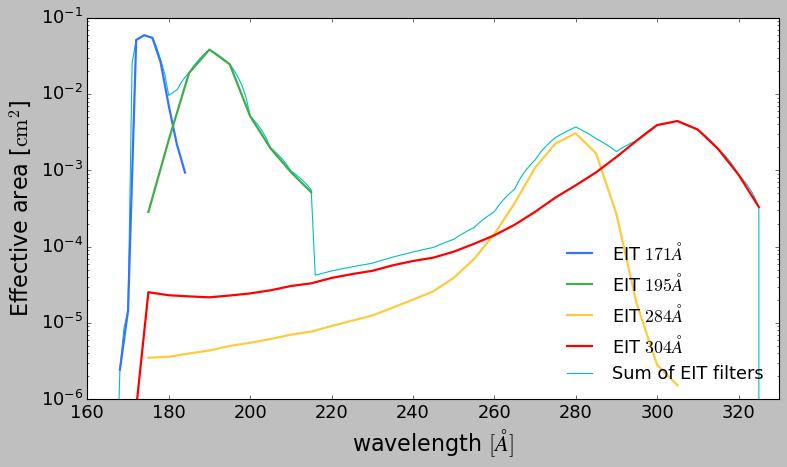

In [121]:

fig, ax = plt.subplots(1,1,figsize=(10,6))

ax.set_xlabel(r'wavelength $[\AA]$', fontsize=20)
#ax.set_ylabel(r'Filter efficiency'+'\n'+r'$[(\mathrm{DN} \mathrm{s}^{-1}) / (\mathrm{photon}\ \mathrm{cm}^{-2} \mathrm{s}^{-1} \mathrm{sr}^{-1} \AA^{-1})]$',fontsize=20)
ax.set_ylabel(r'Effective area '+r'[$\mathrm{cm}^2$]',fontsize=20)
ax.plot(filt171[:,0],filt171[:,3],ls='-',color='#3772ff',label=r'EIT $171\AA$',lw=2,zorder=2)
ax.plot(filt195[:,0],filt195[:,3],ls='-',color='#41ad49',label=r'EIT $195\AA$',lw=2,zorder=2)
ax.plot(filt284[:,0],filt284[:,3],ls='-',color='#fdca40',label=r'EIT $284\AA$',lw=2,zorder=2)
ax.plot(filt304[:,0],filt304[:,3],ls='-',color='r',label=r'EIT $304\AA$',lw=2,zorder=2)
ax.plot(filterSumWavelengths, filterSumTransmission,ls='-',color='c',label='Sum of EIT filters',lw=1,zorder=1)
ax.set_yscale("log")

ax.tick_params(axis='y',labelsize=16)
ax.tick_params(axis='x',labelsize=16)
ax.set_ylim(10**-6, 10**-1)
ax.set_xlim(160,330)
ax.legend(loc='best',frameon=False,prop={'size': 16})

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()
plt.savefig("./EITbandpasses.pdf",bbox_inches="tight")

[5.0000e-01 6.0000e-01 7.0000e-01 ... 2.4021e+03 2.4022e+03 2.4023e+03]
[3.10627800e-07 1.13403632e-06 1.95744484e-06 ... 1.87405980e-02
 1.24937320e-02 6.24686600e-03]


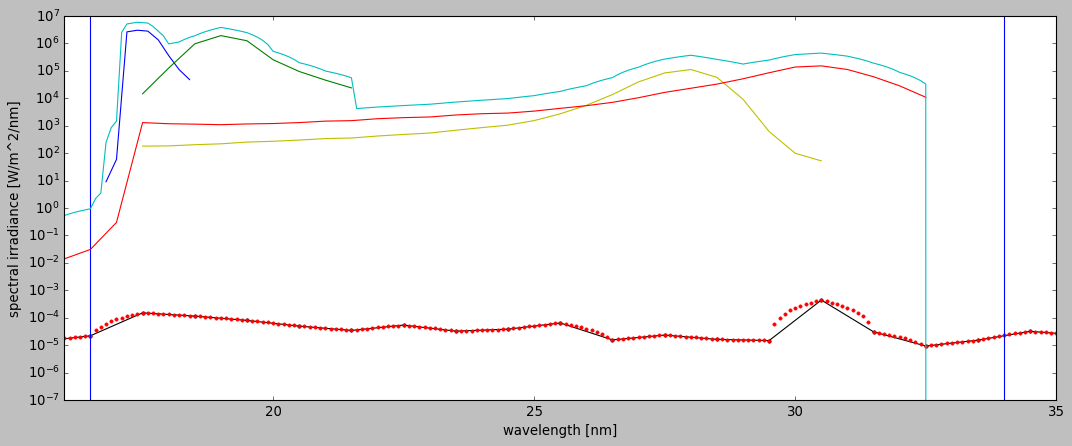

In [122]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
#ax.errorbar(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'], yerr=sorce[mask]['irradiance_uncertainty'], marker='.',capsize=0,elinewidth=1, ms=2, alpha=0.5,ls='-')
ax.plot(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'], 'k-',marker='.')

i_w, i_f = linearlyInterpolateSpectrumAngstroms(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'])
print(i_w)
print(i_f)
ax.plot(i_w, i_f, 'r.')


ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("spectral irradiance [W/m^2/nm]")
ax.set_xlim(16,35)
ax.axvline(16.5)
ax.axvline(34)

ax.plot(filt171[:,0]/10,filt171[:,1]*1.e8,'b-')
ax.plot(filt195[:,0]/10,filt195[:,1]*1.e8,'g-')
ax.plot(filt284[:,0]/10,filt284[:,1]*1.e8,'y-')
ax.plot(filt304[:,0]/10,filt304[:,1]*1.e8,'r-')
ax.plot(filterSumWavelengths/10, filterSumTransmission*1.e8,'c-')
ax.set_yscale("log")

#ax.set_ylim(1.e-6, 5.e-4)
plt.show()

In [123]:
def spectrum_through_filter(wavelength, flux, filterWavelength, filterTransmission):

    interpFlux = np.interp(filterWavelength, wavelength, flux)
    transmittedFlux = interpFlux*filterTransmission

    transmittedFlux_total = np.sum(transmittedFlux)
    #assume blanket 30% flux uncertainty on XPS data (see lab notebook pgs 191-192)
    transmittedFlux_total_unc = np.sum(0.3*interpFlux*filterTransmission)
    
    return transmittedFlux_total, transmittedFlux_total_unc

In [124]:
"""
testI, testT = spectrum_through_filter(sorce[mask]['avg_wavelength']*10, 
                                       sorce[mask]['irradiance'],
                                       filt171[:,0],
                                       filt171[:,1])



fig, ax = plt.subplots(1,1,figsize=(16,8))

i_w, i_f = linearlyInterpolateSpectrumAngstroms(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'])

ax.plot(i_w*10, i_f, 'r.')

plotFac = 1.e10

ax.plot(filt171[:,0],filt171[:,1]*plotFac,'b-')
ax.plot(filt195[:,0],filt195[:,1]*plotFac,'g-')
ax.plot(filt284[:,0],filt284[:,1]*plotFac,'y-')
ax.plot(filt304[:,0],filt304[:,1]*plotFac,'r-')

ax.plot(filt171[:,0], testT*plotFac, 'k-', lw=2)

ax.set_yscale("log")
ax.set_xlim(160,320)
#ax.set_ylim(0.,0.0005)
plt.show()
"""

'\ntestI, testT = spectrum_through_filter(sorce[mask][\'avg_wavelength\']*10, \n                                       sorce[mask][\'irradiance\'],\n                                       filt171[:,0],\n                                       filt171[:,1])\n\n\n\nfig, ax = plt.subplots(1,1,figsize=(16,8))\n\ni_w, i_f = linearlyInterpolateSpectrumAngstroms(sorce[mask][\'avg_wavelength\'], sorce[mask][\'irradiance\'])\n\nax.plot(i_w*10, i_f, \'r.\')\n\nplotFac = 1.e10\n\nax.plot(filt171[:,0],filt171[:,1]*plotFac,\'b-\')\nax.plot(filt195[:,0],filt195[:,1]*plotFac,\'g-\')\nax.plot(filt284[:,0],filt284[:,1]*plotFac,\'y-\')\nax.plot(filt304[:,0],filt304[:,1]*plotFac,\'r-\')\n\nax.plot(filt171[:,0], testT*plotFac, \'k-\', lw=2)\n\nax.set_yscale("log")\nax.set_xlim(160,320)\n#ax.set_ylim(0.,0.0005)\nplt.show()\n'

In [127]:
# Calculate the transmitted flux through each SoHO filter for each XPS spectrum.
# create an array of shape (number of XPS spectra, 5)
# column 0 is date
# column 1 is flux transmitted through 171 filter
# ... 
# column 4 is flux transmitted through 304 filter

XPSsorce = sorce[XPSmask]
uniqueDates = np.sort(np.unique(XPSsorce['jd']))
numDates = len(uniqueDates)

transmittedFlux = np.zeros((numDates, 11))

for i, d in enumerate(uniqueDates):
    mask = XPSsorce['jd'] == d

    #assume blanket 30% flux uncertainty on XPS data (see lab notebook pgs 191-192)
    f171, u171 = spectrum_through_filter(XPSsorce[mask]['avg_wavelength']*10, XPSsorce[mask]['irradiance'],filt171[:,0],filt171[:,3])
    f195, u195 = spectrum_through_filter(XPSsorce[mask]['avg_wavelength']*10, XPSsorce[mask]['irradiance'],filt195[:,0],filt195[:,3])
    f284, u284 = spectrum_through_filter(XPSsorce[mask]['avg_wavelength']*10, XPSsorce[mask]['irradiance'],filt284[:,0],filt284[:,3])
    f304, u304 = spectrum_through_filter(XPSsorce[mask]['avg_wavelength']*10, XPSsorce[mask]['irradiance'],filt304[:,0],filt304[:,3])

    fUV, uUV = spectrum_through_filter(XPSsorce[mask]['avg_wavelength']*10, XPSsorce[mask]['irradiance'],filterSumWavelengths,filterSumTransmission)

    transmittedFlux[i,0] = d
    transmittedFlux[i,1] = f171
    transmittedFlux[i,2] = u171
    transmittedFlux[i,3] = f195
    transmittedFlux[i,4] = u195
    transmittedFlux[i,5] = f284
    transmittedFlux[i,6] = u284
    transmittedFlux[i,7] = f304
    transmittedFlux[i,8] = u304
    transmittedFlux[i,9] = fUV
    transmittedFlux[i,10] = uUV
    
np.savetxt("./SORCE/SORCEfluxTransmittedThroughEITFilters.txt", transmittedFlux, fmt='%.18e', header = 'date[JD] transmitted_flux_171[arb.units] transmitted_flux_171_unc[arb.units] transmitted_flux_195[arb.units] transmitted_flux_195_unc[arb.units] transmitted_flux_284[arb.units] transmitted_flux_284_unc[arb.units] transmitted_flux_304[arb.units] transmitted_flux_304_unc[arb.units] transmitted_flux_sumEITBands[arb.units] transmitted_flux_sumEITBands_unc[arb.units]')


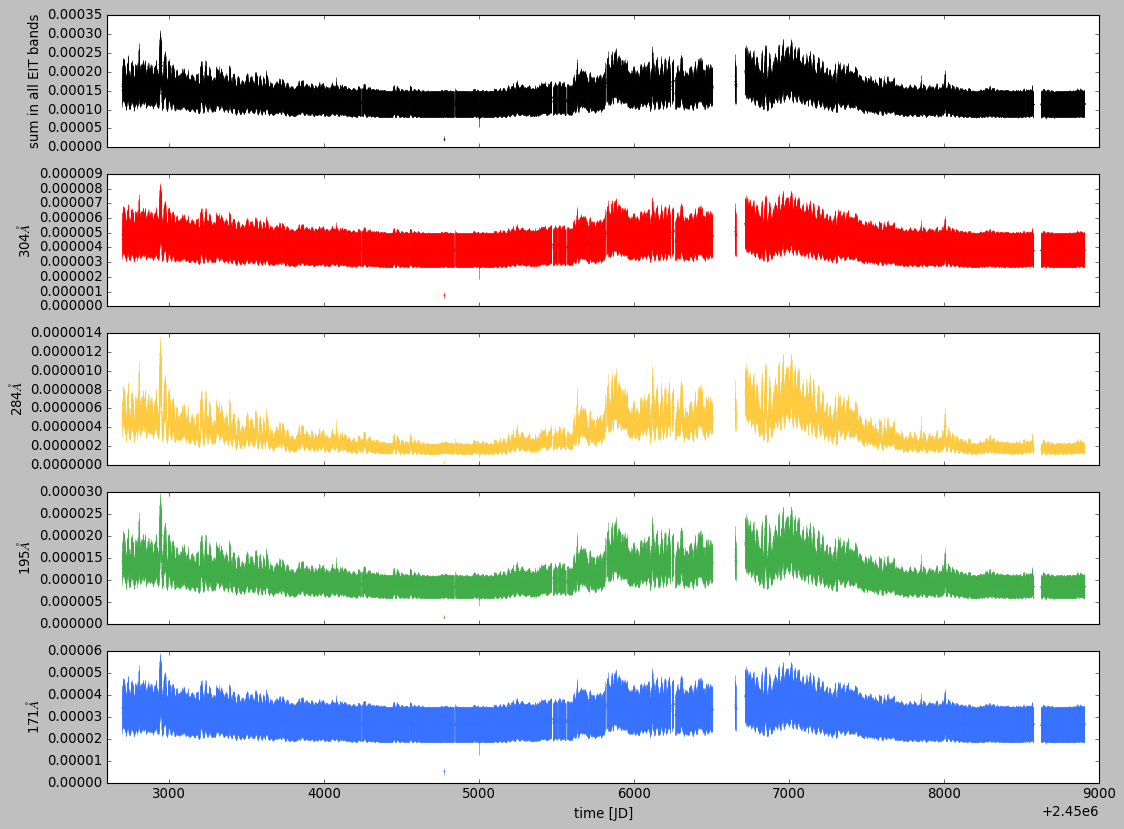

In [128]:
fig, axes = plt.subplots(5,1, sharex=True,figsize=(16,12))
axes[0].errorbar(transmittedFlux[:,0], transmittedFlux[:,9], transmittedFlux[:,10], marker='.',ms=2,ls='None',color='k',elinewidth=0.5,capsize=0)
axes[1].errorbar(transmittedFlux[:,0], transmittedFlux[:,7], transmittedFlux[:,8], marker='.',ms=2,ls='None',color='r',elinewidth=0.5,capsize=0)
axes[2].errorbar(transmittedFlux[:,0], transmittedFlux[:,5], transmittedFlux[:,6],marker='.',ms=2,ls='None',color='#fdca40',elinewidth=0.5,capsize=0)
axes[3].errorbar(transmittedFlux[:,0], transmittedFlux[:,3], transmittedFlux[:,4],marker='.',ms=2,ls='None',color='#41ad49',elinewidth=0.5,capsize=0)
axes[4].errorbar(transmittedFlux[:,0], transmittedFlux[:,1], transmittedFlux[:,2],marker='.',ms=2,ls='None',color='#3772ff',elinewidth=0.5,capsize=0)

axes[0].set_ylabel("sum in all EIT bands")
axes[1].set_ylabel(r"304$\AA$")
axes[2].set_ylabel(r"284$\AA$")
axes[3].set_ylabel(r"195$\AA$")
axes[4].set_ylabel(r"171$\AA$")

axes[4].set_xlabel("time [JD]")
for ax in axes:
    ax.set_xlim(2452600, 2459000)
#plt.show()
plt.savefig("SORCEfluxTransmittedThroughEITFilters.pdf",bbox_inches='tight')

# Flux *ratios* over time 
# Use 304A as denominator bc least affected by activity 

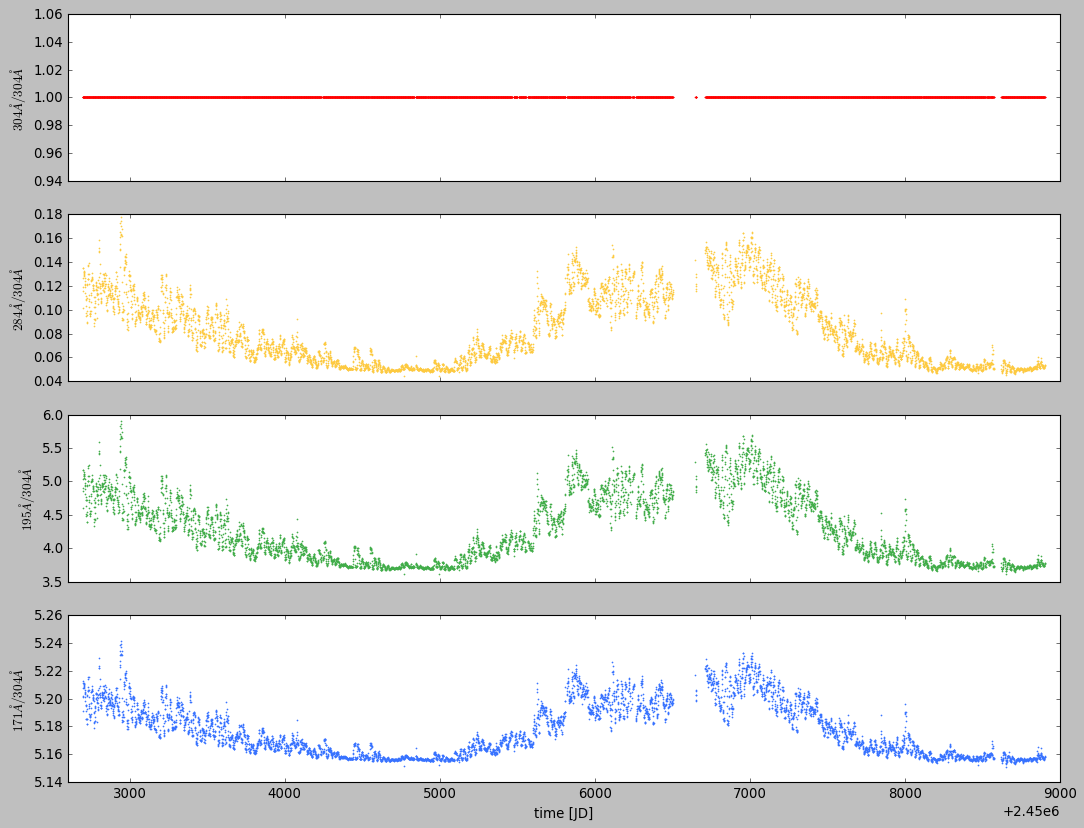

In [32]:
fig, axes = plt.subplots(4,1, sharex=True,figsize=(16,12))
axes[0].plot(transmittedFlux[:,0], transmittedFlux[:,7]/transmittedFlux[:,7],marker='.',ms=2,ls='None',color='r')
axes[1].plot(transmittedFlux[:,0], transmittedFlux[:,5]/transmittedFlux[:,7],marker='.',ms=2,ls='None',color='#fdca40')
axes[2].plot(transmittedFlux[:,0], transmittedFlux[:,3]/transmittedFlux[:,7],marker='.',ms=2,ls='None',color='#41ad49')
axes[3].plot(transmittedFlux[:,0], transmittedFlux[:,1]/transmittedFlux[:,7],marker='.',ms=2,ls='None',color='#3772ff')

axes[0].set_ylabel(r"$304\AA/304\AA$")
axes[1].set_ylabel(r"$284\AA/304\AA$")
axes[2].set_ylabel(r"$195\AA/304\AA$")
axes[3].set_ylabel(r"$171\AA/304\AA$")

axes[3].set_xlabel("time [JD]")
for ax in axes:
    ax.set_xlim(2452600, 2459000)
plt.show()

<>:22: SyntaxWarning: invalid escape sequence '\A'
<>:22: SyntaxWarning: invalid escape sequence '\A'
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_15311/2682534105.py:22: SyntaxWarning: invalid escape sequence '\A'
  axes[2].set_xlabel("$304\AA$")


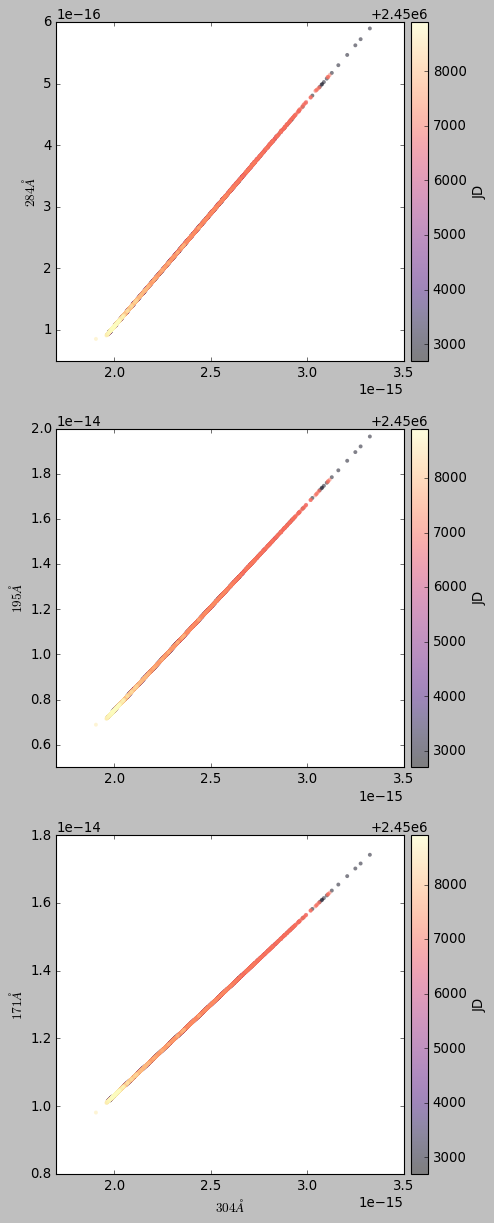

In [33]:
fig, axes = plt.subplots(3,1,figsize=(6,18))

c0=axes[0].scatter(transmittedFlux[:,7], transmittedFlux[:,5],marker='.',s=50,ls='None',c=transmittedFlux[:,0],edgecolor='None',cmap='magma',alpha=0.5)
c1=axes[1].scatter(transmittedFlux[:,7], transmittedFlux[:,3],marker='.',s=50,ls='None',c=transmittedFlux[:,0],edgecolor='None',cmap='magma',alpha=0.5)
c2=axes[2].scatter(transmittedFlux[:,7], transmittedFlux[:,1],marker='.',s=50,ls='None',c=transmittedFlux[:,0],edgecolor='None',cmap='magma',alpha=0.5)

c_s = [c0,c1,c2]

for i, ax in enumerate(axes):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad="2%")
    fig.add_axes(cax)
    fig.colorbar(c_s[i], cax=cax,label="JD")
    
    ax.set_xlim(1.7e-15, 3.5e-15)
    #ax.set_xlim(2.e-15, 2.3e-15)

axes[0].set_ylabel(r"$284\AA$")
axes[1].set_ylabel(r"$195\AA$")
axes[2].set_ylabel(r"$171\AA$")

axes[2].set_xlabel("$304\AA$")

axes[0].set_ylim(0.5e-16,6.e-16)
axes[1].set_ylim(0.5e-14,2.e-14)
axes[2].set_ylim(0.8e-14,1.8e-14)
#axes[0].set_ylim(1.e-16,2.e-16)
#axes[1].set_ylim(0.7e-14,1.e-14)
#axes[2].set_ylim(1.e-14,1.2e-14)
plt.show()

# completely linear relationship between all 4, because there really is not enough information in the SORCE spectrum (it's effectively like convolving each EIT filter with a flat line.)